In [9]:
import flowkit as fk
import xml.etree.ElementTree as ET
import numpy as np
import flowkit as fk
import pandas as pd
import seaborn as sns
import os
from zipfile import ZipFile
import re
import flowio
from flowio import read_multiple_data_sets

from fcs_anonymisation.loading import read_analysis
#from fcs_anonymisation.loading import SampleManualCompensation


fcs_pattern = re.compile(r".*\.fcs$")
xml_pattern = re.compile(r".*\.xml$")

import io
import tempfile
from zipfile import ZipFile


XML_PATH = "/home/jonalegr/Datasets/MockDataCHU/BASSET_CHENETRE Annie Moelle ELN 08 12 22 00027691 792-check comp FILO/000011.xml"
sample_a = read_analysis(
    "mock_dataset/Moreau Camille moelle bla bla-bla_bla 5855.analysis"
)
#sample_b = read_analysis(
#    "mock_dataset/BDX-LOHYP26401764 Moelle bla bla-bla_bla 7267.analysis"
#)

In [10]:
from fcs_anonymisation.loading import get_mappings
from natsort import natsort_keygen, natsorted

def read_compensation(xml_path: str) -> fk.Matrix:
    """
    Read manual compensation matrix from xml files.
    Use a lot of natsorting so that FL1 < FL2 < FL10 and not FL1 < FL10 < FL2
    Not natsorting leads to funny compensation bugs.

    Args:
        xml_path (str): path to the xml file from analysis archive,
        which contains the manual compensation.

    Returns:
        fk.Matrix: Flowkit compensation matrix, with properly sorted channels
    """
    tree = ET.parse(xml_path)
    retrieve_list = tree.findall(".//Compensation")
    assert len(retrieve_list) == 1, "That's weird"
    compensation_element = retrieve_list[0]

    generator = (child.attrib for child in compensation_element.find("S"))
        
        
    compensation_df = pd.DataFrame(generator).sort_values(by="S", key=natsort_keygen())

    label_mapping, channel_mapping = get_mappings(tree)

    compensation_df["S"] = compensation_df["S"].apply(lambda x: channel_mapping[x])
    compensation_df["C"] = compensation_df["C"].apply(lambda x: channel_mapping[x])

    p = compensation_df.pivot(index="S", columns="C", values="V").astype(float)
    p = p.sort_index(key=natsort_keygen()).reindex(natsorted(p.columns), axis=1)
    p.fillna(0, inplace=True)
    np.fill_diagonal(p.values, 1)
    
    sources = p.index.to_list()
    fluorochromes = [label_mapping[el] for el in sources]
    
    matrix = fk.Matrix(p.values, sources, fluorochromes)

    return matrix
mat = read_compensation(
    XML_PATH
)

In [12]:
mat.as_dataframe()

,FL1 INT,FL2 INT,FL3 INT,FL4 INT,FL5 INT,FL6 INT,FL7 INT,FL8 INT,FL9 INT,FL10 INT
FL1 INT,1.000,0.009,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.000
FL2 INT,0.230,1.000,0.098,0.000,0.009,0.000,0.000,0.000,0.000,0.000
FL3 INT,0.074,0.395,1.000,0.000,0.004,0.000,0.000,0.000,0.000,0.000
FL4 INT,0.008,0.070,0.272,1.000,0.001,0.001,0.000,0.000,0.000,0.000
FL5 INT,0.004,0.019,0.099,0.562,1.000,0.001,0.003,0.022,0.000,0.000
FL6 INT,0.000,0.000,0.003,0.090,0.000,1.000,0.047,0.113,0.000,0.000
FL7 INT,0.000,0.000,0.000,0.771,0.008,0.581,1.000,0.143,0.000,0.000
FL8 INT,0.000,0.000,0.001,0.176,0.088,0.089,0.176,1.000,0.000,0.000
FL9 INT,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.023
FL10 INT,0.078,0.181,0.012,0.000,0.002,0.000,0.000,0.000,0.141,1.000


<Axes: >

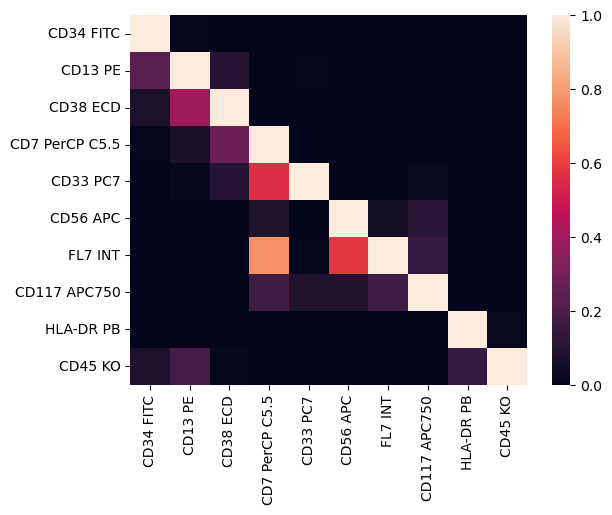

In [3]:
sns.heatmap(mat.as_dataframe(fluoro_labels=True))

<Axes: >

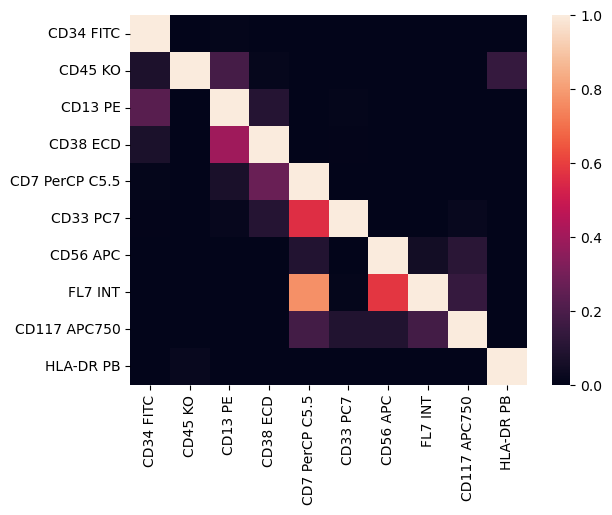

In [39]:
df = mat.as_dataframe()
sns.heatmap(mat.as_dataframe(fluoro_labels=True))

<Axes: >

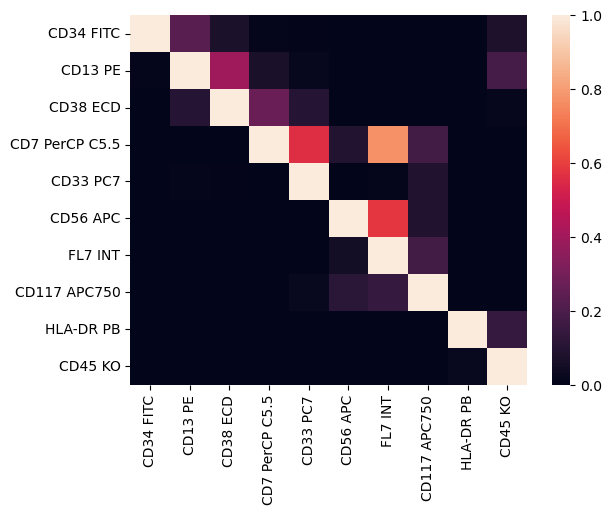

In [13]:
loaded = pd.read_csv(
    "debug_output/sub-BASSET_CHENETRE Annie Moelle ELN 08 12 22 00027691 792-check comp FILO.analysis_specimen-marrow/sub-BASSET_CHENETRE Annie Moelle ELN 08 12 22 00027691 792-check comp FILO.analysis_specimen-marrow_compensation.csv",
    index_col=0)

sns.heatmap(loaded)

<Axes: >

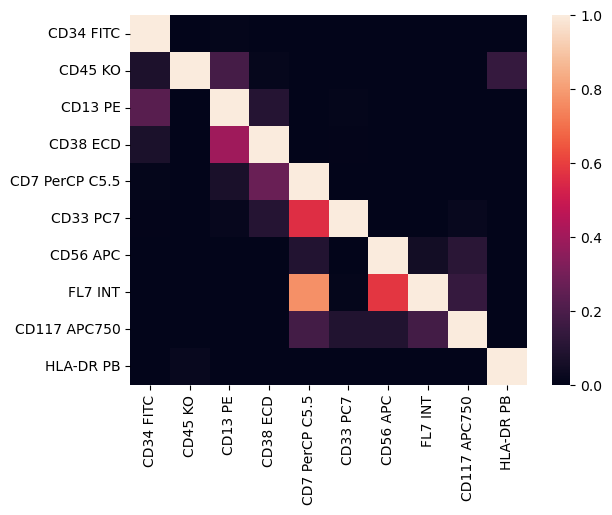

In [15]:
sns.heatmap(mat.as_dataframe(fluoro_labels=True))

In [4]:
xform = fk.transforms.AsinhTransform(
    param_t=5, param_m=1, param_a=1
)
class CustomSample(fk.Sample):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        # Correct channel idx issues
        if self.pnn_labels[0]=='FS PEAK':
            self.fluoro_indices=[3,4,5,6,7,8,9,10,11,12]
            self.scatter_indices=[1,2]
        else:
            self.fluoro_indices=[2,3,4,5,6,7,8,9,10,11]
            self.scatter_indices=[0,1]

        spill = self.get_metadata()['spill']

        detectors = [self.pnn_labels[i] for i in self.fluoro_indices]
        fluorochromes = [self.pns_labels[i] for i in self.fluoro_indices]

        # Apply compensation
        self.compensation = fk.Matrix(spill, detectors, fluorochromes)
        self._comp_events = self.compensation.apply(self)
        self.tube = self.original_filename.split("_")[1].split(" ")[-1]
        
        self.apply_transform(xform)

        # Reset subsample indices to account for removed clipped rows
        if "subsample" in kwargs.keys():
            subsample = kwargs["subsample"]
        else:
            subsample = None
       # self.subsample_events(subsample)

<Axes: >

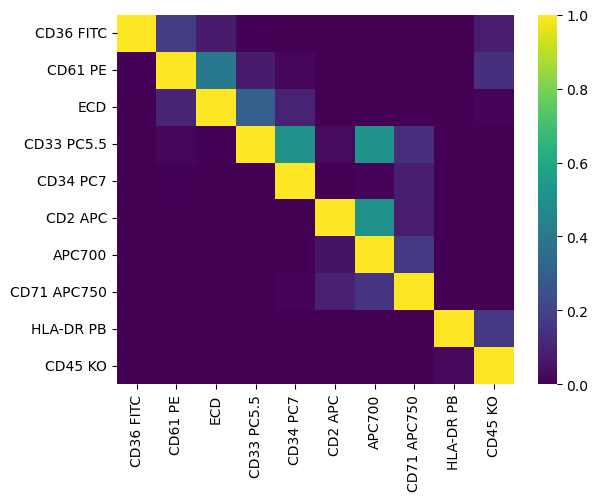

In [14]:
import seaborn as sns
sns.heatmap(s.compensation.as_dataframe(fluoro_labels=True), cmap="viridis")

In [15]:
s = CustomSample("/home/jonalegr/FCS_CPaleari/Raw/Patient9_LAM 10C Tube C_26-Feb-21.fcs")
from bokeh.io import show
xform = fk.transforms.AsinhTransform(
    param_t=5, param_m=1, param_a=1
)
s.apply_transform(xform)
p = s.plot_scatter_matrix(source="xform")
show(p)